# Intro ML Homework 6
## Name: Jaskin Kabir
## Student ID: 801186717
Github: https://github.com/jaskinkabir/Intro_ML/tree/main/HM5

In [86]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn

path = 'housing.csv'
housing = pd.DataFrame(pd.read_csv(path))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

df_train, df_test = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

Y_train_tensor_p1 = df_train.pop('price')
X_train = df_train

Y_test_tensor_p1 = df_test.pop('price')
X_test_batch = df_test
X_train.head()


b_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_p3 = housing[b_vars]
X_train_df_p3 = X_train[b_vars]
X_test_df_p3 = X_test_batch[b_vars]

X_train_tensor_p1 = X_train_df_p3.to_numpy()
X_test_tensor_p1 = X_test_df_p3.to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train_tensor_p1)
X_train_tensor_p1 = scaler.transform(X_train_tensor_p1)
X_test_tensor_p1 = scaler.transform(X_test_tensor_p1)




In [87]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

class Regressor(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print(100 * (results1 - results2) / results1)
        
    def __init__(self, in_dim, out_dim, hidden_layers=[64,32], activation=nn.Tanh,):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.input_cols = []
        self.output_cols = []
        
        #Error Mode is a 5 bit integer, with each bit representing a feature
        # If the bit is 1, the feature is errored
        output_features = out_dim
        input_features = in_dim
        

        
        self.stack_list = [nn.Linear(input_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_features)])
        self.stack = nn.Sequential(*self.stack_list)
        
        
        
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha=1e-2, loss_fn=nn.MSELoss(),):
        
        val_hist = np.zeros(epochs)
        train_hist = np.zeros(epochs)

        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        for i in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred.squeeze(), Y_train)
            loss.backward()
            optimizer.step()
            train_hist[i] = np.sqrt(loss.item())
            
            
            with torch.no_grad():
                Y_pred_val = self.forward(X_test)
                val_hist[i] = np.sqrt(loss_fn(Y_pred_val, Y_test).item())
            
        self.last_test = Y_test_tensor_p1
        self.last_pred = self.forward(X_test)
        self.last_score = val_hist[-1]
        
        self.last_epochs = epochs
        self.last_val_hist = val_hist
        self.last_train_hist = train_hist
    
    def plot_loss(self, title):
        
        plt.plot(range(self.last_epochs), self.last_val_hist, label='Validation Loss')
        plt.plot(range(self.last_epochs), self.last_train_hist, label='Training Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('RMS Loss')
        plt.legend()
        plt.show()
        
    def forward(self, x):
        return self.stack(x)
    
    def print_results(self):
        if self.last_score is None:
            raise ValueError('No results to print')
        print(f'MSE: {self.last_score:.2E}')
        
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_val=0.0):
        super(CustomMSELoss, self).__init__()
        self.lambda_val = lambda_val
    
    def forward(self, predictions, targets):

        m = targets.size(0)
        
        errors = predictions - targets
        mse_loss = (1 / (2*m)) * torch.sum(errors ** 2)
        

        

        total_loss = mse_loss
        
        return total_loss

/home/jaskin/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([436, 1])) that is different to the input size (torch.Size([436])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


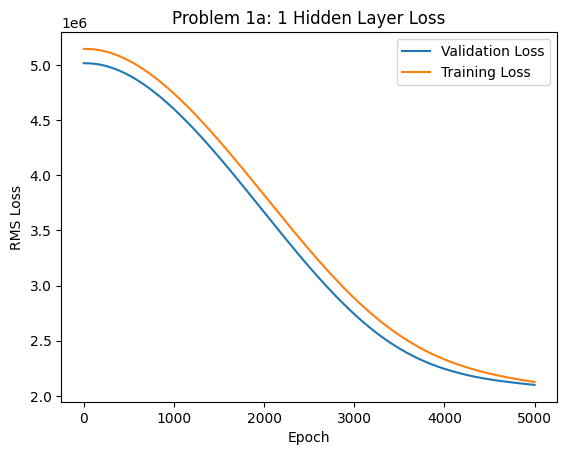

MSE: 2.10E+06


In [88]:
device = 'cpu'


X_train_tensor_p1 = torch.tensor(X_train_tensor_p1).to(device).float()
X_test_tensor_p1 = torch.tensor(X_test_tensor_p1).to(device).float()

Y_train_tensor_p1 = torch.tensor(Y_train_tensor_p1.to_numpy()).to(device).float().view(-1, 1)
Y_test_tensor_p1 = torch.tensor(Y_test_tensor_p1.to_numpy()).to(device).float().view(-1, 1)


model_1a = Regressor(
    in_dim=X_train_tensor_p1.shape[1],
    out_dim=1,
    hidden_layers=[8],
    activation=nn.ReLU,
).to(device)

model_1a.train(
    epochs=5000,
    X_train=X_train_tensor_p1,
    X_test=X_test_tensor_p1,
    Y_train=Y_train_tensor_p1,
    Y_test=Y_test_tensor_p1,
    alpha=1e-1,
    loss_fn=nn.MSELoss(),
)

model_1a.plot_loss('Problem 1a: 1 Hidden Layer Loss')
model_1a.print_results()

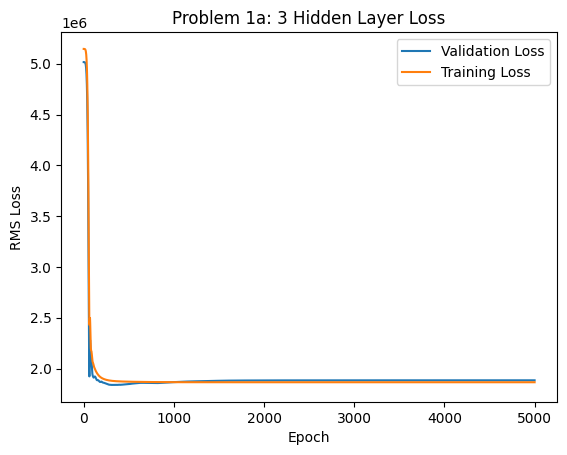

MSE: 1.88E+06


In [89]:
model_1b = Regressor(
    in_dim=X_train_tensor_p1.shape[1],
    out_dim=1,
    hidden_layers=[8,16,8],
    activation=nn.ReLU,
).to(device)


model_1b.train(
    epochs=5000,
    X_train=X_train_tensor_p1,
    X_test=X_test_tensor_p1,
    Y_train=Y_train_tensor_p1,
    Y_test=Y_test_tensor_p1,
    alpha=1e-1,
    loss_fn=nn.MSELoss(),
)

model_1b.plot_loss('Problem 1a: 3 Hidden Layer Loss')
model_1b.print_results()

In [90]:
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
X_2 = breast.data
Y_2 = breast.target

X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, train_size=0.8, test_size=0.2, random_state=00)

scaler = preprocessing.StandardScaler().fit(X_train_2)
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)


In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred),
            'recall': recall_score(Y_test, Y_pred),
            'f1': f1_score(Y_test, Y_pred),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
                
    
class LogisticClassifier(Classifier):        
    def __init__(self, input_dim=0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        if pass_through:
            return
        self.stack_list = [nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.extend([nn.Linear(hidden_layers[-1], 1), nn.Sigmoid()]) 
        self.stack = nn.Sequential(*self.stack_list)
        
    def forward(self, x):
        return self.stack(x)
    
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).round()
    
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha, loss_fn=nn.BCELoss(), print_epoch=500):
        optimizer = torch.optim.SGD(self.parameters(), lr=alpha)

        for epoch in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred, Y_train)
            loss.backward()
            optimizer.step()
            if epoch % print_epoch == 0:
                test_loss = loss_fn(self.forward(X_test), Y_test)
                print(f'Epoch {epoch}: Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        Y_pred = self.predict(X_test)
        self.last_pred = Y_pred
        self.last_test = Y_test
        return [Y_test,Y_pred]
    


In [92]:
X_train_2 = torch.tensor(X_train_2).to(device).float()
X_test_2 = torch.tensor(X_test_2).to(device).float()
Y_train_2 = torch.tensor(Y_train_2).to(device).float().view(-1, 1)
Y_test_2 = torch.tensor(Y_test_2).to(device).float().view(-1, 1)

model_2a = LogisticClassifier(
    input_dim=X_train_2.shape[1],
    hidden_layers=[32],
    activation=nn.ReLU
).to(device)

model_2a.train(
    epochs=5000,
    X_train=X_train_2,
    X_test=X_test_2,
    Y_train=Y_train_2,
    Y_test=Y_test_2,
    alpha=1e-1,
    loss_fn=nn.BCELoss(),
    print_epoch=500
)

results_2a = model_2a.get_results()
model_2a.print_results(results_2a)

Epoch 0: Training Loss: 0.6494768261909485, Test Loss: 0.622453510761261
Epoch 500: Training Loss: 0.04857287555932999, Test Loss: 0.10514752566814423
Epoch 1000: Training Loss: 0.03554915264248848, Test Loss: 0.11781139671802521
Epoch 1500: Training Loss: 0.027439016848802567, Test Loss: 0.12369734793901443
Epoch 2000: Training Loss: 0.021537767723202705, Test Loss: 0.12544722855091095
Epoch 2500: Training Loss: 0.0172867588698864, Test Loss: 0.1253926008939743
Epoch 3000: Training Loss: 0.01401909627020359, Test Loss: 0.12533463537693024
Epoch 3500: Training Loss: 0.011520844884216785, Test Loss: 0.12215476483106613
Epoch 4000: Training Loss: 0.009578595869243145, Test Loss: 0.11738007515668869
Epoch 4500: Training Loss: 0.0079865213483572, Test Loss: 0.11180971562862396
Accuracy: 0.9736842105263158
Precision: 0.9848484848484849
Recall: 0.9701492537313433
F1: 0.9774436090225563
Confusion_matrix:
[[46  1]
 [ 2 65]]
Classification_report:
              precision    recall  f1-score   s

In [93]:
model_2b = LogisticClassifier(
    input_dim=X_train_2.shape[1],
    hidden_layers=[32,64,32],
    activation=nn.ReLU
).to(device)

model_2b.train(
    epochs=5000,
    X_train=X_train_2,
    X_test=X_test_2,
    Y_train=Y_train_2,
    Y_test=Y_test_2,
    alpha=5e-2,
    loss_fn=nn.BCELoss(),
    print_epoch=500
)
print('\n')
results_2b = model_2b.get_results()
model_2b.print_results(results_2b)

Epoch 0: Training Loss: 0.7098226547241211, Test Loss: 0.7019134163856506
Epoch 500: Training Loss: 0.048219744116067886, Test Loss: 0.08267858624458313
Epoch 1000: Training Loss: 0.026169275864958763, Test Loss: 0.09044355899095535
Epoch 1500: Training Loss: 0.013049769215285778, Test Loss: 0.1043962761759758
Epoch 2000: Training Loss: 0.006730714347213507, Test Loss: 0.10144830495119095
Epoch 2500: Training Loss: 0.0037905662320554256, Test Loss: 0.09607496857643127
Epoch 3000: Training Loss: 0.002368505345657468, Test Loss: 0.0893516093492508
Epoch 3500: Training Loss: 0.001618517329916358, Test Loss: 0.08530494570732117
Epoch 4000: Training Loss: 0.0011932974448427558, Test Loss: 0.08247081935405731
Epoch 4500: Training Loss: 0.0009260816150344908, Test Loss: 0.08084322512149811


Accuracy: 0.9649122807017544
Precision: 0.9846153846153847
Recall: 0.9552238805970149
F1: 0.9696969696969697
Confusion_matrix:
[[46  1]
 [ 3 64]]
Classification_report:
              precision    recall  

In [1]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


NameError: name 'torch' is not defined

In [95]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)
X_test_3 = torch.stack([img for img, _ in cifar10_test], dim=3).view(3, -1).to(device=device)
Y_test_3 = torch.tensor([label for _, label in cifar10_test]).to(device=device)




Files already downloaded and verified
Files already downloaded and verified


In [153]:
import time

class ImageClassifier(Classifier):
    def __init__(self, input_dim=0, output_dim = 0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        self.stack_list = [nn.Flatten(), nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_dim), nn.Softmax(dim=1)])
        self.stack = nn.Sequential(*self.stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        alpha,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=10,
    ):
        
        optimizer = optimizer(self.parameters(), lr=alpha)
        training_time = 0
        for epoch in range(epochs):
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            training_time += time.time() - start_time
            
            
            self.eval()
            with torch.no_grad():
                test_loss = 0
                Y_pred_eval = []
                Y_test = []
                for X_test_batch, Y_test_batch in test_loader:
                    X_test_batch, Y_test_batch = X_test_batch.to(device), Y_test_batch.to(device)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch).item()
                    Y_test.extend(Y_test_batch.cpu().detach().numpy())
                    Y_pred_eval.extend(out.argmax(dim=1).cpu().detach().numpy())
                
            accuracy = accuracy_score(Y_test, Y_pred_eval)
            if epoch % print_epoch == 0:
                print(f'Epoch {epoch}: Training Loss: {train_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}, Accuracy: {accuracy}')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_test = torch.tensor(Y_test)
        print(f'\nTraining Time: {training_time} seconds\n')

            
            

In [130]:
device = 'cuda'
model_3a = ImageClassifier(
    input_dim=3*32*32,
    output_dim=10,
    hidden_layers=[256],
    activation=nn.Tanh
).to(device)

model_3a.train_model(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=1e-2,
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)



Epoch 0: Training Loss: 2.200853923397601, Test Loss: 2.1516819759538977, Accuracy: 0.3338
Epoch 1: Training Loss: 2.1331590911006684, Test Loss: 2.1160234448256765, Accuracy: 0.3595
Epoch 2: Training Loss: 2.1084186001811798, Test Loss: 2.098708185420674, Accuracy: 0.3774
Epoch 3: Training Loss: 2.0925817105471327, Test Loss: 2.0848600978304628, Accuracy: 0.388
Epoch 4: Training Loss: 2.0803749402770606, Test Loss: 2.0754607027503336, Accuracy: 0.3968
Epoch 5: Training Loss: 2.0705192675980766, Test Loss: 2.068637213889201, Accuracy: 0.4044
Epoch 6: Training Loss: 2.062044849176236, Test Loss: 2.062760948375532, Accuracy: 0.4083
Epoch 7: Training Loss: 2.054948158123914, Test Loss: 2.0574175347188475, Accuracy: 0.4144
Epoch 8: Training Loss: 2.0486589962869046, Test Loss: 2.0535211935164823, Accuracy: 0.4176
Epoch 9: Training Loss: 2.0431769331702796, Test Loss: 2.0501046932426985, Accuracy: 0.4208
Epoch 10: Training Loss: 2.038143223356408, Test Loss: 2.0466429701276647, Accuracy: 0.

AttributeError: 'NoneType' object has no attribute 'to'

In [137]:
model_3a_results = model_3a.get_results()
model_3a.print_results(model_3a_results)

AttributeError: 'list' object has no attribute 'cpu'

Noticed the SGD optimizer is much slower than Adam, but yields more consistent results. To improve the model performance, the alpha was increased to 1e-2 to deal with the lower learning rate of SGD

In [154]:
device = 'cuda'
model_3b = ImageClassifier(
    input_dim=3*32*32,
    output_dim=10,
    hidden_layers=[1],#[256,384,256],
    activation=nn.Tanh
).to(device)

model_3b.train_model(
    epochs=1,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=1e-2,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer = torch.optim.SGD,
    print_epoch=1
)

model_3b_results = model_3a.get_results()
model_3b.print_results(model_3a_results)

Epoch 0: Training Loss: 2.2863482285643477, Test Loss: 2.283533647561529, Accuracy: 0.1639

Training Time: 10.48029613494873 seconds



AttributeError: 'list' object has no attribute 'cpu'